# Learn OpenAI Whisper - Chapter 5
## Notebook 4: Voice and Image assistant with Whisper and Llava

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1NnvYEMQbAdaY5DtqXciytxL1d5UjnMIc)

[Llava](https://huggingface.co/llava-hf/llava-1.5-7b-hf) is a multi-modal image-text to text model that can be seen as an "open source version of GPT4-vision".

![image/png](https://cdn-uploads.huggingface.co/production/uploads/62441d1d9fdefb55a0b7d12c/FPshq08TKYD0e-qwPLDVO.png)

The architecutre is a pure decoder-based text model that takes concatenated vision hidden states with text hidden states.

We will leverage QLoRA quantization method and use `pipeline` to run our model.

This notebook is designed to demonstrate the integration of OpenAI's Whisper and Hugging Face's Llava models to create a voice and image assistant. The notebook serves as a practical example of how to use these models in tandem to process and interpret both audio and visual data. The primary goal is to showcase the capabilities of Llava as a multi-modal image-text to text model, which is described as an "open source version of GPT-4," and to illustrate how it can be combined with Whisper's audio processing to build a comprehensive multi-modal AI system.

### Main code sections and their functions

1. **Setting up the environment**: The initial code cells are responsible for installing the necessary libraries and dependencies, such as `transformers`, `bitsandbytes`, `accelerate`, `whisper`, `gradio`, and `gTTS`. Additionally, a temporary audio file is created using `ffmpeg` to facilitate audio processing.

2. **Configuring quantization**: This section includes code to prepare the quantization configuration, which is essential for loading the Llava model with 4-bit precision. This step is crucial for optimizing the model's performance in terms of memory and speed.

3. **Initializing the Llava model**: Here we log into the Hugging Face Hub and initialize the `image-to-text` pipeline with the Llava model, applying the quantization configuration prepared earlier. This pipeline is used to process images and generate descriptive text.

4. **Processing images**: This section downloads a set of images and selects one to be processed. The selected image is then loaded and displayed using the `PIL` library.

5. **Generating text from images**: This section prompts the Llava model to describe the loaded image in detail. It uses a specific format for the prompt and processes the output to extract and print the generated text.

6. **Processiung audio**: The Whisper model is loaded, and a function is defined to transcribe audio input into text. This section also includes code to check for GPU availability, which is preferred for running Whisper.

7. **Logging notebook activity**: A logging function is included to record the history of inputs and outputs, which can be useful for debugging and tracking the system's performance.

8. **Defining supporting functions**: The following functions convert image-to-text output using `Llava`, transcribe speech-to-text using `Whisper`, and speech-to-text usin `gTTS` which is then saved as an audio file.

9. **Running the Gradio interface**: The final section of the notebook sets up a Gradio interface that allows users to interact with the system by uploading images and providing voice input. The interface processes the inputs using the defined functions for image description and audio transcription, and it provides audio and text outputs.

In summary, the notebook is structured to first set up the environment, then load and configure the models, followed by defining functions for processing images and audio, and finally, creating an interactive interface for users to engage with the multi-modal AI system.

1. **Setting up the environment**

    The initial code cells are responsible for installing the necessary libraries and dependencies, such as `transformers`, `bitsandbytes`, `accelerate`, `whisper`, `gradio`, and `gTTS`. Additionally, a temporary audio file is created using `ffmpeg` to facilitate audio processing.

In [1]:
%%capture
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q git+https://github.com/openai/whisper.git
!pip install -q gradio
!pip install -q gTTS
!ffmpeg -f lavfi -i anullsrc=r=44100:cl=mono -t 10 -q:a 9 -acodec libmp3lame Temp.mp3

## Preparing the quantization config to load the model in 4bit precision

2. **Configuring quantization**: This section includes code to prepare the quantization configuration, which is essential for loading the Llava model with 4-bit precision. This step is crucial for optimizing the model's performance in terms of memory and speed.

In [2]:
import torch
from transformers import BitsAndBytesConfig

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

We will leverage the `image-to-text` pipeline from transformers !

3. **Initializing the Llava model**

    Here we log into the Hugging Face Hub and initialize the `image-to-text` pipeline with the Llava model, applying the quantization configuration prepared earlier. This pipeline is used to process images and generate descriptive text.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

In [4]:
from huggingface_hub import whoami

whoami()
# you should see something like {'type': 'user',  'id': '...',  'name': 'Wauplin', ...}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:80: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


{'type': 'user',
 'id': '6404c20d3d49e1e066b97c10',
 'name': 'jbatista79',
 'fullname': 'Josue Batista',
 'email': 'josue@josuebatista.com',
 'emailVerified': True,
 'canPay': False,
 'periodEnd': None,
 'isPro': False,
 'avatarUrl': '/avatars/e686904a94e267b4570907a7e734fbb4.svg',
 'orgs': [],
 'auth': {'type': 'access_token',
  'accessToken': {'displayName': 'Whisper Fine-Tuning', 'role': 'write'}}}

In [5]:
from transformers import pipeline

model_id = "llava-hf/llava-1.5-7b-hf"

pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.33k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


preprocessor_config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

In order to load the model in 4-bit precision, we need to pass a `quantization_config` to our model. Let's do that in the cells below

## Load an image

4. **Processing images**

    This section downloads a set of images and selects one to be processed. The selected image is then loaded and displayed using the `PIL` library.

In [6]:
import whisper
import gradio as gr
import time
import warnings
import os
from gtts import gTTS

In [7]:
for i in range(1, 11):
    !wget -nv https://github.com/PacktPublishing/Learn-OpenAI-Whisper/raw/main/Chapter05/images/LOAIW_ch05_image_{str(i).zfill(2)}.jpg

2024-04-11 13:28:14 URL:https://raw.githubusercontent.com/PacktPublishing/Learn-OpenAI-Whisper/main/Chapter05/images/LOAIW_ch05_image_01.jpg [24512/24512] -> "LOAIW_ch05_image_01.jpg" [1]
2024-04-11 13:28:14 URL:https://raw.githubusercontent.com/PacktPublishing/Learn-OpenAI-Whisper/main/Chapter05/images/LOAIW_ch05_image_02.jpg [23737/23737] -> "LOAIW_ch05_image_02.jpg" [1]
2024-04-11 13:28:15 URL:https://raw.githubusercontent.com/PacktPublishing/Learn-OpenAI-Whisper/main/Chapter05/images/LOAIW_ch05_image_03.jpg [40665/40665] -> "LOAIW_ch05_image_03.jpg" [1]
2024-04-11 13:28:15 URL:https://raw.githubusercontent.com/PacktPublishing/Learn-OpenAI-Whisper/main/Chapter05/images/LOAIW_ch05_image_04.jpg [52700/52700] -> "LOAIW_ch05_image_04.jpg" [1]
2024-04-11 13:28:15 URL:https://raw.githubusercontent.com/PacktPublishing/Learn-OpenAI-Whisper/main/Chapter05/images/LOAIW_ch05_image_05.jpg [48398/48398] -> "LOAIW_ch05_image_05.jpg" [1]
2024-04-11 13:28:16 URL:https://raw.githubusercontent.com/Pa

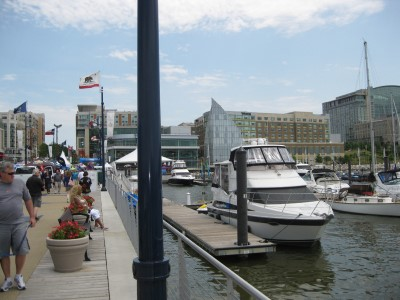

In [8]:
from PIL import Image

image_path = "/content/LOAIW_ch05_image_10.jpg"
image = Image.open((image_path))
image

## Load the model using `pipeline`

5. **Generating text from images**
    This section prompts the Llava model to describe the loaded image in detail. It uses a specific format for the prompt and processes the output to extract and print the generated text.

It is important to prompt the model wth a specific format, which is:
```bash
USER: <image>\n<prompt>\nASSISTANT:
```

In [9]:
import nltk
nltk.download('punkt')
from nltk import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
max_new_tokens = 200

prompt_instructions = """
Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
"""

prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})
# outputs
# print(outputs[0]["generated_text"])
for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

USER:  

Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
ASSISTANT: The image is a photograph of a harbor with several boats docked.
The boats are of various sizes and are lined up along the pier.
The harbor is situated next to a large building, which could be a hotel or a commercial building.
There are several people in the scene, some of them standing near the boats, while others are scattered throughout the harbor area.
A few chairs are also present, with one chair located near the left side of the image and another chair closer to the right side.
The overall atmosphere of the scene suggests a bustling harbor with people enjoying the view and the boats.


6. **Processing speech-to-text**

    The Whisper model is loaded, and a function is defined to transcribe audio input into text. This section also includes code to check for GPU availability, which is preferred for running Whisper.

In [11]:
import warnings
from gtts import gTTS
import numpy as np
import torch
warnings.filterwarnings("ignore")
torch.cuda.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using torch {torch.__version__} ({DEVICE})")

Using torch 2.2.1+cu121 (cuda)


Please keep in mind, that there are multiple different models available. You can find all of them [here](https://github.com/openai/whisper/blob/main/model-card.md). Each one of them has tradeoffs between accuracy and speed (compute needed). We will use the 'medium' model for this tutorial.

Using a GPU is the preferred way to use Whisper. If you are using a local machine, you can check if you have a GPU available. The first line results `False`, if Cuda compatible Nvidia GPU is not available and `True` if it is available. The second line of code sets the model to preference GPU whenever it is available.

In [12]:
#Now we can load the Whipser model. The model is loaded with the following command:
import whisper
model = whisper.load_model("medium", device=DEVICE)
print(
    f"Model is {'multilingual' if model.is_multilingual else 'English-only'} "
    f"and has {sum(np.prod(p.shape) for p in model.parameters()):,} parameters."
)

100%|██████████████████████████████████████| 1.42G/1.42G [00:12<00:00, 122MiB/s]


Model is multilingual and has 762,321,920 parameters.


In [13]:
import requests
import re
from PIL import Image


input_text = 'Describe the largest boat in the image.'
input_image = '/content/LOAIW_ch05_image_10.jpg'

# load the image
image = Image.open(input_image)

# print(input_text)
prompt_instructions = """
Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
""" + input_text

prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"
outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])

if match:
    # Extract the text after "ASSISTANT:"
    extracted_text = match.group(1)
    print(extracted_text)
else:
    print("No match found.")

for sent in sent_tokenize(outputs[0]["generated_text"]):
    print(sent)

The largest boat in the image is a white yacht, which is docked at a pier. It is a prominent feature in the scene, and its size and design make it stand out among the other boats in the harbor. The yacht appears to be well-maintained and ready for use, suggesting that it may be a popular choice among boat owners or enthusiasts.
USER:  

Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
Describe the largest boat in the image.
ASSISTANT: The largest boat in the image is a white yacht, which is docked at a pier.
It is a prominent feature in the scene, and its size and design make it stand out among the other boats in the harbor.
The yacht appears to be well-maintained and ready for use, suggesting that it may be a popular choice among boat owners or enthusiasts.


7. **Defining supporting functions**

    The following cells define functions that convert image-to-text output using `Llava`, transcribe speech-to-text using `Whisper`, and speech-to-text using `gTTS` which is then saved as an audio file.


In [14]:
import re
import requests
from PIL import Image

def img2txt(input_text, input_image):

    # load the image
    image = Image.open(input_image)

    # writehistory(f"Input text: {input_text} - Type: {type(input_text)} - Dir: {dir(input_text)}")
    if type(input_text) == tuple:
        prompt_instructions = """
        Describe the image using as much detail as possible, is it a painting, a photograph, what colors are predominant, what is the image about?
        """
    else:
        prompt_instructions = """
        Act as an expert in imagery descriptive analysis, using as much detail as possible from the image, respond to the following prompt:
        """ + input_text

    prompt = "USER: <image>\n" + prompt_instructions + "\nASSISTANT:"

    outputs = pipe(image, prompt=prompt, generate_kwargs={"max_new_tokens": 200})

    # Properly extract the response text
    if outputs is not None and len(outputs[0]["generated_text"]) > 0:
        match = re.search(r'ASSISTANT:\s*(.*)', outputs[0]["generated_text"])
        if match:
            # Extract the text after "ASSISTANT:"
            reply = match.group(1)
        else:
            reply = "No response found."
    else:
        reply = "No response generated."

    return reply

In [15]:
def transcribe(audio):

    # Check if the audio input is None or empty
    if audio is None or audio == '':
        return ('','',None)  # Return empty strings and None audio file

    # language = 'en'

    audio = whisper.load_audio(audio)
    audio = whisper.pad_or_trim(audio)

    mel = whisper.log_mel_spectrogram(audio).to(model.device)

    _, probs = model.detect_language(mel)

    options = whisper.DecodingOptions()
    result = whisper.decode(model, mel, options)
    result_text = result.text

    return result_text

In [16]:
def text_to_speech(text, file_path):
    language = 'en'

    audioobj = gTTS(text = text,
                    lang = language,
                    slow = False)

    audioobj.save(file_path)

    return file_path

8. **Running the Gradio interface**

    The final section of the notebook sets up a Gradio interface that allows users to interact with the system by uploading images and providing voice input. The interface processes the inputs using the defined functions for image description and audio transcription, and it provides audio and text outputs.

In [18]:
import gradio as gr
import base64
import os

# A function to handle audio and image inputs
def process_inputs(audio_path, image_path):
    # Process the audio file (assuming this is handled by a function called 'transcribe')
    speech_to_text_output = transcribe(audio_path)

    # Handle the image input
    if image_path:
        chatgpt_output = img2txt(speech_to_text_output, image_path)
    else:
        chatgpt_output = "No image provided."

    # Assuming 'transcribe' also returns the path to a processed audio file
    processed_audio_path = text_to_speech(chatgpt_output, "Temp3.mp3")  # Replace with actual path if different

    return speech_to_text_output, chatgpt_output, processed_audio_path

# Create the interface
iface = gr.Interface(
    fn=process_inputs,
    inputs=[
        gr.Audio(sources=["microphone"], type="filepath"),
        gr.Image(type="filepath")
    ],
    outputs=[
        gr.Textbox(label="Speech to Text"),
        gr.Textbox(label="ChatGPT Output"),
        gr.Audio("Temp.mp3")
    ],
    title="Learn OpenAI Whisper: Image processing with Whisper, Llava, and gTTS",
    description="Upload an image and interact via voice input and audio response."
)

# Launch the interface
iface.launch(debug=False)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5bd79d5649e44dfd18.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
